In [1]:
push!(LOAD_PATH,".")
using ListType, OptionType, Chakra, Nova
using Viewpoints, PPM
using CSV, DataFrames
using Plots
using Profile

In [2]:
melodies = map(fn->string("nova/",fn,"/track1"),readdir("nova"))
id_seqs = [obind(find(m,data),particles) for m in melodies]
seqs = [Chakra.sequence(s,data) for s in id_seqs]
pitch_view = [PPM.View(seq,vp(:pitch),vp(:pitch)) for seq in seqs];

# Parameters

In [3]:
a = Set([54:77...,79,81])
b = Backoff()
e = A()
u = false
#o = Bounded(5)
o = Unbounded();

# Short-term model

In [4]:
@time stm = PPM.ppm_stm(pitch_view,a,b,e,u,o);

  1.447973 seconds (9.19 M allocations: 941.891 MiB, 15.37% gc time, 47.78% compilation time)


# Long-term model

In [11]:
@time ltm = PPM.ppm_ltm(pitch_view,a,b,e,u,o,10);

Folding dataset...
  0.000608 seconds (79 allocations: 81.859 KiB)
Creating dbs...
  7.444200 seconds (31.21 M allocations: 3.100 GiB, 27.70% gc time)
 11.583909 seconds (41.96 M allocations: 4.286 GiB, 34.17% gc time, 9.60% compilation time)


# Combined model

In [12]:
model = stm
#@time model = [[PPM.combine(Prediction[p1,p2];b=1) for (p1,p2) in zip(s,l)] for (s,l) in zip(stm,ltm)];

# Print table 

In [13]:
table = PPM.todataframe(model)

,SeqID,EventID,Symbol,Order,Prob,IC,H
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,1,65,-1,0.0384615,4.70044,4.70044
2,1,2,62,-1,0.0196078,5.67243,3.27612
3,1,3,60,-1,0.0135135,6.20945,3.07171
4,1,4,60,0,0.252632,1.98489,3.09494
5,1,5,60,1,0.503497,0.989946,2.51433
6,1,6,60,1,0.669767,0.578268,1.92239
7,1,7,65,0,0.0836237,3.57994,1.56165
8,1,8,65,0,0.143284,2.80305,1.99356
9,1,9,65,1,0.334262,1.58095,2.10954


In [14]:
symbols = table.Symbol
probabilities = table.Prob
orders = table.Order
df = CSV.File("./idyom-data/STMA*.csv") |> DataFrame;
idyom_probs = df[!,"probability"]
idyom_ics = df[!,"information.content"];
DataFrame(Symbol = symbols, IdyomProb = idyom_probs, JuliaProb = probabilities)

,Symbol,IdyomProb,JuliaProb
,Int64,Float64,Float64
1,65,0.0384615,0.0384615
2,62,0.0196078,0.0196078
3,60,0.0135135,0.0135135
4,60,0.252632,0.252632
5,60,0.503497,0.503497
6,60,0.669767,0.669767
7,65,0.0836237,0.0836237
8,65,0.143284,0.143284
9,65,0.334262,0.334262


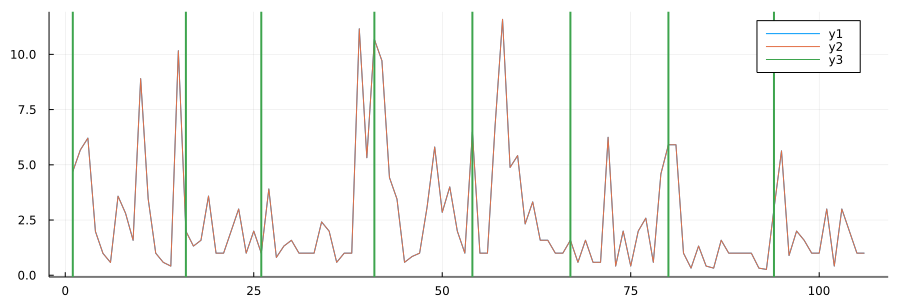

In [15]:
#base = length(a)
#logn = [log(base,x) for x in 1:106]
plot(idyom_ics[1:106])
plot!(table.IC[1:106])
#plot!(orders[500:600],lw = 3)
#plot!(logn,lw = 2)
idyom_phrase = findall(x->x==1,df[!,"phrase"][1:106]);
vline!(idyom_phrase, lw = 2)
plot!(size=(900,300))

In [18]:
sum(values(model[3][11].distribution))

0.9999999999999999